In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torchvision import transforms, models

from google.colab import files

from tqdm.notebook import tqdm

In [2]:
def upload_image():
  image = files.upload()
  file_name = list(image.keys())[0]

  print()
  print(f'uploaded file: {file_name}')

  return file_name

In [3]:
def open_image(image_path, max_size=400):
  image = Image.open(image_path).convert('RGB')

  size = min(max_size, max(image.size))

  transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
  ])

  image = transform(image)[:3,:,:].unsqueeze(0)

  return image

In [4]:
def convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [5]:
def get_features(model, image, layers):
  features = {}

  x = image
  for name, layer in model._modules.items():
    x = layer(x)

    if name in layers:
      features[layers[name]] = x

  return features

In [6]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()

  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [7]:
def content_loss(target_features, content_features, layer):
  return torch.mean((target_features[layer] - content_features[layer]) ** 2)

In [8]:
def style_loss(target_features, style_grams, weights):
  loss = 0

  for layer in weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]

    layer_loss = weights[layer] * torch.mean((target_gram - style_gram) ** 2)

    _, d, w, h = target_feature.shape
    loss += layer_loss / (d * w * h)

  return loss

In [9]:
def transfer(content, style, layers, layers_weight, steps, content_weight, style_weight):
  content_features = get_features(vgg, content, layers)
  style_features = get_features(vgg, style, layers)

  style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  target = content_image.clone().requires_grad_(True).to(device)

  optimizer = optim.Adam([target], lr=3e-3)

  for i in tqdm(range(1, steps+1)):
    target_features = get_features(vgg, target, layers)

    content_loss_val = content_loss(target_features, content_features, 'conv4_2')
    style_loss_val = style_loss(target_features, style_gram, layers_weight)

    loss = content_weight * content_loss_val + style_weight * style_loss_val

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return target

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
content_path = upload_image()
style_path = upload_image()

content_image = open_image(content_path).to(device)
style_image = open_image(style_path).to(device)

Saving octopus.jpg to octopus (1).jpg

uploaded file: octopus.jpg


Saving delaunay.jpg to delaunay (1).jpg

uploaded file: delaunay.jpg


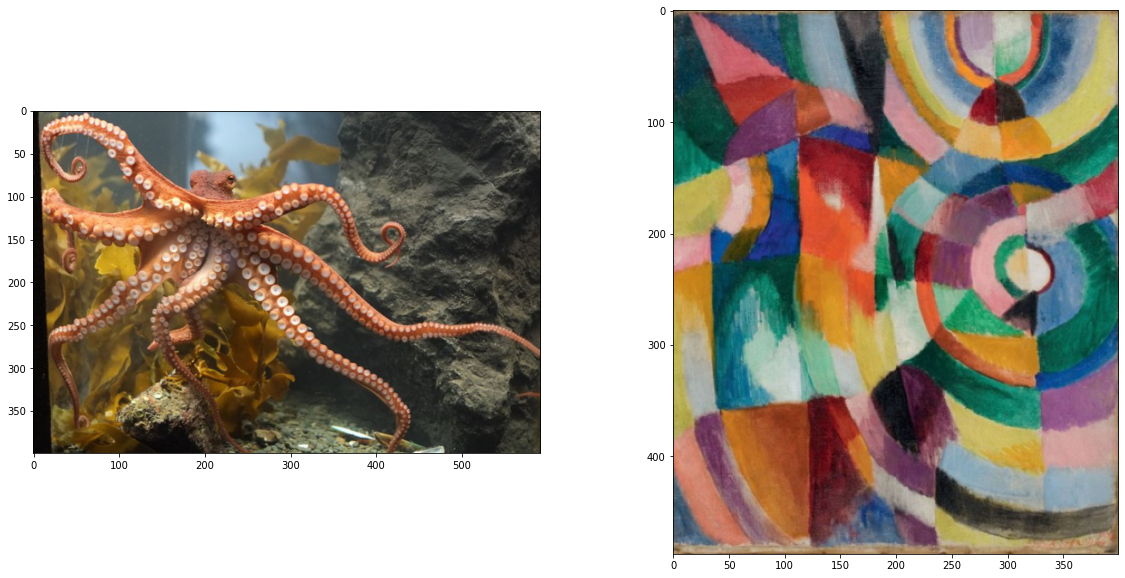

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(convert(content_image))
ax2.imshow(convert(style_image))

In [13]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

vgg = vgg.to(device)

In [14]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [15]:
layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}

In [16]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

In [17]:
target = transfer(content=content_image,
                  style=style_image,
                  layers=layers,
                  layers_weight=style_weights,
                  steps=2000,
                  content_weight=content_weight,
                  style_weight=style_weight)

  0%|          | 0/2000 [00:00<?, ?it/s]

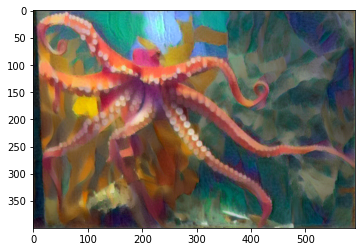

In [20]:
plt.imshow(convert(target))

In [18]:
image = convert(target)

image = Image.fromarray(np.uint8((image)*255))
image.save('result.jpg')

In [19]:
files.download('result.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>